<a href="https://colab.research.google.com/github/primroseisaseal/Cryptocurrencies-forecast/blob/main/Code_1st_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [182]:
pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Multivariate LSTM 5 Open Close High low volumn 

In [184]:
yf.pdr_override()
BTC = pdr.get_data_yahoo('BTC' , start="2019-01-01", end="2022-06-15" )
BTC = BTC.reset_index()

BTC_1 = BTC.drop(['Volume', 'Adj Close'], axis = 1)
# BTC_2 = BTC

# Split train test with 65% train
train_size = int(len(BTC)*0.65)
BTC_train = BTC_1.iloc[:train_size,1:]

BTC_test = BTC_1.iloc[train_size:,1:]
BTC_test['Close']=BTC_test['Close'].astype('float64')

# For Training Set, split into X (Open, High, low, CLose) and y (Close) then scale it
sc = MinMaxScaler(feature_range=(0,1))
data_train_scaled = sc.fit_transform(BTC_train)

sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(BTC_train[['Close']])

# create 3D df for LSTM
hop = 2
X_train = []
y_train = []
for i in range(hop, train_size):
  X_train.append(data_train_scaled[i-hop:i])
  y_train.append(y_train_scaled[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))

#fit trian df into the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)






[*********************100%***********************]  1 of 1 completed
Epoch 1/100
9/9 [==============================] - 17s 24ms/step - loss: 0.3396
Epoch 2/100
9/9 [==============================] - 0s 23ms/step - loss: 0.2561
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1218
Epoch 4/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0433
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0337
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0313
Epoch 7/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0266
Epoch 8/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0219
Epoch 9/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0169
Epoch 10/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0146
Epoch 11/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 12/100
9/9 [==============================] - 0s 18ms

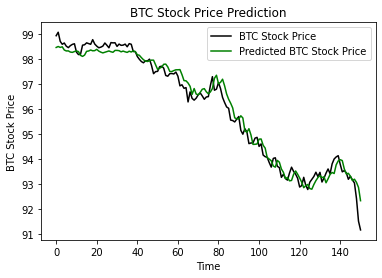

In [185]:
# Prepaering for test data set
train_lasthopdays = BTC_train.iloc[-hop:]
full_df = pd.concat((train_lasthopdays,BTC_test), axis =0)
full_df

full_df_scaled = sc.fit_transform(full_df)
full_df_scaled.shape

X_test = []

for i in range(hop, len(full_df_scaled)):
  X_test.append(full_df_scaled[i-hop:i])

X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
X_test.shape

full_df_scaled = pd.DataFrame(full_df_scaled)
full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1]

y_pred = model.predict(X_test)
len(y_pred)


y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.rename(columns = {0 :'Close_pred'})

full_df_scaled = pd.DataFrame(full_df_scaled)
toinv_full = full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1].reset_index()
toinv_full = toinv_full.iloc[:,1:]
# toinv_full = toinv_full.rename(columns = list(BTC_2))
toinv_full
# print(y_pred)


to_inv = pd.concat((toinv_full,y_pred), axis = 1)
to_inv

y_final_pred = sc.inverse_transform(to_inv)
y_final_pred = pd.DataFrame(y_final_pred)
# y_final_pred = y_final_pred.rename(columns = {0 :'Open', 1: 'High', 2:'low', 3:'Close_pred'})
y_final_pred

full_final_df = pd.concat((BTC_test.reset_index(), y_final_pred.iloc[:,-1:]), axis =1)
full_final_df

plt.plot(full_final_df['Close'], color = 'black', label = 'BTC Stock Price')
plt.plot(full_final_df.iloc[:,-1:], color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [186]:
Close_pred = full_final_df.iloc[:,-1:].values
Close_actual = full_final_df['Close'].values
print(f'test RSME: {math.sqrt(mean_squared_error(Close_actual,Close_pred))}')

test RSME: 0.3403811112961429


# Multivariate LSTM 31 features from 

Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [188]:
# import data set which I calculate 30 features from other .ipynb file 
url = 'https://raw.githubusercontent.com/primroseisaseal/Cryptocurrencies-forecast/main/Feature%2018.csv'
BTC_2 = pd.read_csv(url)
BTC_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     366 non-null    object 
 1   OpenRSI_x                366 non-null    float64
 2   OpenSMA3                 366 non-null    float64
 3   Diff_OpenSMA3_x          366 non-null    float64
 4   OpenEMA5                 366 non-null    float64
 5   Diff_OpenEMA5            366 non-null    float64
 6   Movement_OpenEMA5        366 non-null    float64
 7   Diff_Close_x             366 non-null    float64
 8   Movement_Close           366 non-null    float64
 9   CloseRSI_x               366 non-null    float64
 10  Diff_CloseRSI            366 non-null    float64
 11  Movement_closeRSI        366 non-null    float64
 12  CloseEMA5                366 non-null    float64
 13  Diff_CloseEMA5           366 non-null    float64
 14  Movement_Diff_CloseEMA5  3

In [189]:

# Split train test with 65% train
train_size = int(len(BTC)*0.65)
BTC_train = BTC_2.iloc[:train_size,1:]

BTC_test = BTC_2.iloc[train_size:,1:]
BTC_test['Close']=BTC_2_test['Close'].astype('float64')

# For Training Set, split into X (Open, High, low, CLose) and y (Close) then scale it
sc = MinMaxScaler(feature_range=(0,1))
data_train_scaled = sc.fit_transform(BTC_2_train)

sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(BTC_2_train[['Close']])

# create 3D df for LSTM
hop = 2
X_train = []
y_train = []
for i in range(hop, train_size):
  X_train.append(data_train_scaled[i-hop:i])
  y_train.append(y_train_scaled[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))

#fit trian df into the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
9/9 [==============================] - 19s 12ms/step - loss: 0.1209
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0589
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0382
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0327
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0313
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0253
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0231
Epoch 8/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0142
Epoch 9/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0107
Epoch 10/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 11/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0077
Epoch 12/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 13/100
9/9 [==============================

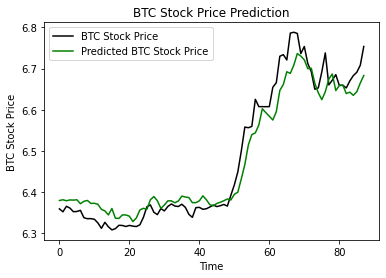

In [190]:
# Prepaering for test data set
train_lasthopdays = BTC_train.iloc[-hop:]
full_df = pd.concat((train_lasthopdays,BTC_test), axis =0)
full_df

full_df_scaled = sc.fit_transform(full_df)
full_df_scaled.shape

X_test = []

for i in range(hop, len(full_df_scaled)):
  X_test.append(full_df_scaled[i-hop:i])

X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
X_test.shape

full_df_scaled = pd.DataFrame(full_df_scaled)
full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1]

y_pred = model.predict(X_test)
len(y_pred)


y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.rename(columns = {0 :'Close_pred'})

full_df_scaled = pd.DataFrame(full_df_scaled)
toinv_full = full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1].reset_index()
toinv_full = toinv_full.iloc[:,1:]
# toinv_full = toinv_full.rename(columns = list(BTC_2))
toinv_full
# print(y_pred)


to_inv = pd.concat((toinv_full,y_pred), axis = 1)
to_inv

y_final_pred = sc.inverse_transform(to_inv)
y_final_pred = pd.DataFrame(y_final_pred)
# y_final_pred = y_final_pred.rename(columns = {0 :'Open', 1: 'High', 2:'low', 3:'Close_pred'})
y_final_pred

full_final_df = pd.concat((BTC_test.reset_index(), y_final_pred.iloc[:,-1:]), axis =1)
full_final_df

plt.plot(full_final_df['Close'], color = 'black', label = 'BTC Stock Price')
plt.plot(full_final_df.iloc[:,-1:], color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [191]:
Close_pred = full_final_df.iloc[:,-1:].values
Close_actual = full_final_df['Close'].values
print(f'test RSME: {math.sqrt(mean_squared_error(Close_actual,Close_pred))}')

test RSME: 0.03885909851996087


# SVR for time series forecasting
https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

In [192]:
# Prepare Data
BTC_svm = BTC.iloc[:, 1:5]
BTC_svm.describe()

,Open,High,Low,Close
count,429.000000,429.000000,429.000000,429.000000
mean,98.216682,98.231323,98.195093,98.210783
std,2.077717,2.072421,2.078751,2.075415
min,91.178398,91.178398,91.178398,91.178398
25%,97.925003,97.925003,97.919998,97.922302
50%,99.000000,99.040001,98.983101,99.008301
75%,99.668999,99.684998,99.655296,99.660004
max,100.889999,100.889999,100.154999,100.154999


In [193]:


#Create dataframe for SVR

df_lagged = BTC_svm.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged

#split training and testing 65% /35%
training_svr = df_lagged.iloc[:train_size,:]
X_train_svr = training_svr.drop('Close',axis =1)
y_train_svr = training_svr['Close']

testing_svr = df_lagged.iloc[train_size:,:]
X_test_svr = testing_svr.drop('Close',axis =1)
y_test_svr = testing_svr['Close']

training_svr.shape, testing_svr.shape

#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1))
training_svr_scaled = sc_df.fit_transform(training_svr)
training_svr_scaled = pd.DataFrame(training_svr_scaled,columns=training_svr.columns.values.tolist())
X_train_svr_scaled = training_svr_scaled.drop('Close',axis =1)


testing_svr_scaled = sc_df.transform(testing_svr)
testing_svr_scaled = pd.DataFrame(testing_svr_scaled,columns=testing_svr.columns.values.tolist())
X_test_svr_scaled = testing_svr_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_svr_scaled = sc_y.transform(np.array(y_train_svr).reshape(-1,1))


#fit svr model into traning set
svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr.fit(X_train_svr_scaled,y_train_svr_scaled)
y_train_svr_pred = svr.predict(X_train_svr_scaled)
y_train_svr_pred

# predict testing set
y_test_svr_pred = svr.predict(X_test_svr_scaled)
y_test_svr_pred = y_test_svr_pred.reshape(-1,1)


y_test_vr_pred_inv = sc_y.inverse_transform(y_test_svr_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_svr,y_test_vr_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 3.9054756834266127


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


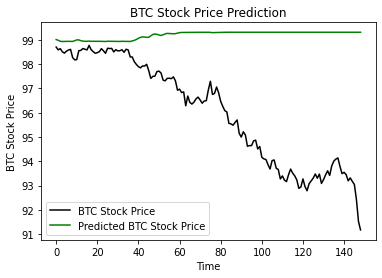

In [194]:
plt.plot(y_test_svr.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_vr_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

# SVR for time series forecasting with 31 Features from:


Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [195]:
# Prepare Data
BTC_svm_2 = BTC_2
BTC_svm_2.reset_index
BTC_svm_2 = BTC_svm_2.drop('Date', axis=1)
BTC_svm_2

,OpenRSI_x,OpenSMA3,Diff_OpenSMA3_x,OpenEMA5,Diff_OpenEMA5,Movement_OpenEMA5,Diff_Close_x,Movement_Close,CloseRSI_x,Diff_CloseRSI,...,Movement_Open,CloseRSI_y,Open_x,Adj Close,Diff_OpenSMA3,Volume_y,Diff_Close_y,Open_y,High,Close
0,0.0,100.013334,0.003334,100.010000,8.477105e-07,1.0,0.034996,1.0,100.0,100.0,...,1.0,0.0,0.84830,0.848000,-0.001557,400531,1.449997,6.7898,6.7900,6.7898
1,0.0,99.996666,-0.016668,99.989999,-2.000116e-02,-1.0,-0.110001,-1.0,0.0,-100.0,...,-1.0,0.0,0.85198,0.851960,0.000163,433065,-0.719997,6.7898,6.7900,6.7898
2,100.0,99.983332,-0.013334,99.989999,-4.709503e-07,-1.0,0.075005,1.0,100.0,100.0,...,1.0,100.0,0.84994,0.849800,-0.001053,409787,1.239998,6.7897,6.7898,6.7897
3,0.0,99.969999,-0.013334,99.983333,-6.665862e-03,-1.0,-0.055000,-1.0,0.0,-100.0,...,1.0,100.0,0.84983,0.849834,0.000510,331703,-0.590000,6.7892,6.7897,6.7892
4,100.0,99.979665,0.010000,99.984468,7.765971e-03,1.0,0.010002,1.0,100.0,0.0,...,-1.0,100.0,0.85150,0.851630,0.000557,328295,0.840000,6.7455,6.7464,6.7455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,93.230667,-0.091665,93.338902,-8.194937e-02,-1.0,-0.142899,-1.0,0.0,-100.0,...,1.0,100.0,0.93470,0.934700,0.001520,340591,2.699997,6.6697,6.6945,6.6697
362,0.0,93.190834,-0.039833,93.252467,-8.643477e-02,-1.0,-0.125000,-1.0,0.0,0.0,...,1.0,0.0,0.93304,0.933040,0.000243,293295,-0.599998,6.6827,6.6975,6.6827
363,0.0,92.991534,-0.199300,93.074978,-1.774886e-01,-1.0,-0.617401,-1.0,0.0,0.0,...,-1.0,100.0,0.94169,0.941690,0.002120,352906,-0.840004,6.6908,6.7163,6.6908
364,0.0,92.523198,-0.468335,92.639984,-4.349939e-01,-1.0,-0.905602,-1.0,0.0,0.0,...,1.0,0.0,0.95329,0.953290,0.006197,372403,0.260002,6.7079,6.7582,6.7079


In [196]:
#Create dataframe for SVR

df_lagged = BTC_svm_2.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm_2.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm_2.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged

#split training and testing 65% /35%
training_svr = df_lagged.iloc[:train_size,:]
X_train_svr = training_svr.drop('Close',axis =1)
y_train_svr = training_svr['Close']

testing_svr = df_lagged.iloc[train_size:,:]
X_test_svr = testing_svr.drop('Close',axis =1)
y_test_svr = testing_svr['Close']

training_svr

#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1))
training_svr_scaled = sc_df.fit_transform(training_svr)
training_svr_scaled = pd.DataFrame(training_svr_scaled,columns=training_svr.columns.values.tolist())
X_train_svr_scaled = training_svr_scaled.drop('Close',axis =1)


testing_svr_scaled = sc_df.transform(testing_svr)
testing_svr_scaled = pd.DataFrame(testing_svr_scaled,columns=testing_svr.columns.values.tolist())
X_test_svr_scaled = testing_svr_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_svr_scaled = sc_y.transform(np.array(y_train_svr).reshape(-1,1))


#fit svr model into traning set
svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr.fit(X_train_svr_scaled,y_train_svr_scaled)
y_train_svr_pred = svr.predict(X_train_svr_scaled)
y_train_svr_pred

# predict testing set
y_test_svr_pred = svr.predict(X_test_svr_scaled)
y_test_svr_pred = y_test_svr_pred.reshape(-1,1)


y_test_vr_pred_inv = sc_y.inverse_transform(y_test_svr_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_svr,y_test_vr_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 0.1651802571770242


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


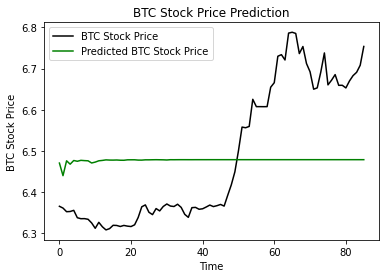

In [197]:
plt.plot(y_test_svr.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_vr_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

#XG boost

In [198]:
pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
# xgboost
import xgboost
from xgboost import XGBRegressor
print("xgboost", xgboost.__version__)

xgboost 1.6.1


In [200]:
#Prepare df for Multivaraite timestep model
BTC_xgb = BTC_1

df_lagged = BTC_svm.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()

df_lagged

,Open,High,Low,Close,Open_lag1,High_lag1,Low_lag1,Close_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2
2,100.029999,100.040001,99.995003,99.995003,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,100.010002,100.029999,100.010002,100.029999,100.029999,100.040001,99.995003,99.995003,100.000000,100.000000,100.000000,100.000000
4,99.949997,99.959999,99.919998,99.919998,100.010002,100.029999,100.010002,100.029999,100.029999,100.040001,99.995003,99.995003
5,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998,100.010002,100.029999,100.010002,100.029999
6,99.970001,99.980003,99.940002,99.940002,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998
...,...,...,...,...,...,...,...,...,...,...,...,...
424,93.175003,93.175003,93.175003,93.175003,93.317902,93.317902,93.317902,93.317902,93.199097,93.199097,93.199097,93.199097
425,93.079597,93.079597,93.050003,93.050003,93.175003,93.175003,93.175003,93.175003,93.317902,93.317902,93.317902,93.317902
426,92.720001,92.720001,92.432602,92.432602,93.079597,93.079597,93.050003,93.050003,93.175003,93.175003,93.175003,93.175003
427,91.769997,91.769997,91.527000,91.527000,92.720001,92.720001,92.432602,92.432602,93.079597,93.079597,93.050003,93.050003


In [201]:
#split training and testing 65% /35%
training_xgb = df_lagged.iloc[:train_size,:]
X_train_xgb = training_xgb.drop('Close',axis =1)
y_train_xgb = training_xgb['Close']

testing_xgb = df_lagged.iloc[train_size:,:]
X_test_xgb = testing_xgb.drop('Close',axis =1)
y_test_xgb = testing_xgb['Close']


#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1)).fit(df_lagged)
training_xgb_scaled = sc_df.transform(training_xgb)
training_xgb_scaled = pd.DataFrame(training_xgb_scaled,columns=training_xgb.columns.values.tolist())
X_train_xgb_scaled = training_xgb_scaled.drop('Close',axis =1)


testing_xgb_scaled = sc_df.transform(testing_xgb)
testing_xgb_scaled = pd.DataFrame(testing_xgb_scaled,columns=testing_xgb.columns.values.tolist())
X_test_xgb_scaled = testing_xgb_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_xgb_scaled = sc_y.transform(np.array(y_train_xgb).reshape(-1,1))

#fit xgb model into traning set
xgb = XGBRegressor()
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train_xgb_scaled,y_train_xgb_scaled)
y_train_xgb_pred = xgb.predict(X_train_xgb_scaled)
y_train_xgb_pred

# predict testing set
y_test_xgb_pred = xgb.predict(X_test_xgb_scaled)
y_test_xgb_pred = y_test_xgb_pred.reshape(-1,1)


y_test_xgb_pred_inv = sc_y.inverse_transform(y_test_xgb_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_xgb,y_test_xgb_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 3.270550217708813


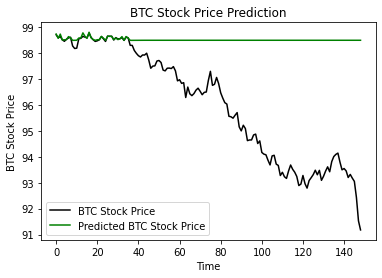

In [202]:
plt.plot(y_test_xgb.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_xgb_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

# XGboost for time series forecasting with 31 Features from:


Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [203]:
#Prepare df for Multivaraite timestep model
BTC_xgb_2 = BTC_2
df_lagged = BTC_xgb_2.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged = df_lagged.drop('Date', axis =1)
df_lagged

,OpenRSI_x,OpenSMA3,Diff_OpenSMA3_x,OpenEMA5,Diff_OpenEMA5,Movement_OpenEMA5,Diff_Close_x,Movement_Close,CloseRSI_x,Diff_CloseRSI,...,High,Close,Open_lag1,High_lag1,Low_lag1,Close_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2
2,100.0,99.983332,-0.013334,99.989999,-4.709503e-07,-1.0,0.075005,1.0,100.0,100.0,...,6.7898,6.7897,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,0.0,99.969999,-0.013334,99.983333,-6.665862e-03,-1.0,-0.055000,-1.0,0.0,-100.0,...,6.7897,6.7892,100.029999,100.040001,99.995003,99.995003,100.000000,100.000000,100.000000,100.000000
4,100.0,99.979665,0.010000,99.984468,7.765971e-03,1.0,0.010002,1.0,100.0,0.0,...,6.7464,6.7455,100.010002,100.029999,100.010002,100.029999,100.029999,100.040001,99.995003,99.995003
5,0.0,99.983332,-0.009666,99.976429,-1.321614e-02,-1.0,-0.019997,-1.0,0.0,0.0,...,6.7246,6.7239,99.949997,99.959999,99.919998,99.919998,100.010002,100.029999,100.010002,100.029999
6,0.0,99.953334,-0.029999,99.954287,-2.214186e-02,-1.0,-0.035004,-1.0,0.0,0.0,...,6.7024,6.6966,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,93.230667,-0.091665,93.338902,-8.194937e-02,-1.0,-0.142899,-1.0,0.0,-100.0,...,6.6945,6.6697,96.464996,96.464996,96.464996,96.464996,96.817802,96.817802,96.817802,96.817802
362,0.0,93.190834,-0.039833,93.252467,-8.643477e-02,-1.0,-0.125000,-1.0,0.0,0.0,...,6.6975,6.6827,96.261902,96.261902,96.261902,96.261902,96.464996,96.464996,96.464996,96.464996
363,0.0,92.991534,-0.199300,93.074978,-1.774886e-01,-1.0,-0.617401,-1.0,0.0,0.0,...,6.7163,6.6908,96.084999,96.084999,96.084999,96.084999,96.261902,96.261902,96.261902,96.261902
364,0.0,92.523198,-0.468335,92.639984,-4.349939e-01,-1.0,-0.905602,-1.0,0.0,0.0,...,6.7582,6.7079,96.030098,96.030098,96.030098,96.030098,96.084999,96.084999,96.084999,96.084999


In [204]:
#split training and testing 65% /35%
training_xgb = df_lagged.iloc[:train_size,:]
X_train_xgb = training_xgb.drop('Close',axis =1)
y_train_xgb = training_xgb['Close']

testing_xgb = df_lagged.iloc[train_size:,:]
X_test_xgb = testing_xgb.drop('Close',axis =1)
y_test_xgb = testing_xgb['Close']


#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1)).fit(df_lagged)
training_xgb_scaled = sc_df.transform(training_xgb)
training_xgb_scaled = pd.DataFrame(training_xgb_scaled,columns=training_xgb.columns.values.tolist())
X_train_xgb_scaled = training_xgb_scaled.drop('Close',axis =1)


testing_xgb_scaled = sc_df.transform(testing_xgb)
testing_xgb_scaled = pd.DataFrame(testing_xgb_scaled,columns=testing_xgb.columns.values.tolist())
X_test_xgb_scaled = testing_xgb_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_xgb_scaled = sc_y.transform(np.array(y_train_xgb).reshape(-1,1))

#fit xgb model into traning set
xgb = XGBRegressor()
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train_xgb_scaled,y_train_xgb_scaled)
y_train_xgb_pred = xgb.predict(X_train_xgb_scaled)
y_train_xgb_pred

# predict testing set
y_test_xgb_pred = xgb.predict(X_test_xgb_scaled)
y_test_xgb_pred = y_test_xgb_pred.reshape(-1,1)


y_test_xgb_pred_inv = sc_y.inverse_transform(y_test_xgb_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_xgb,y_test_xgb_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv

test RSME: 0.013271770907443758


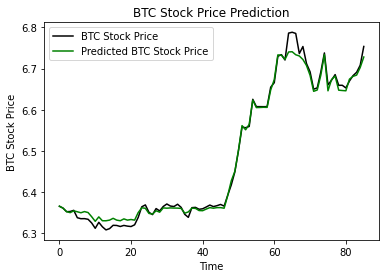

In [205]:
plt.plot(y_test_xgb.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_xgb_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()